<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Key-imports-and-functions" data-toc-modified-id="Key-imports-and-functions-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Key imports and functions</a></span></li><li><span><a href="#Data-import-and-preparation" data-toc-modified-id="Data-import-and-preparation-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Data import and preparation</a></span><ul class="toc-item"><li><span><a href="#Standarizing-data" data-toc-modified-id="Standarizing-data-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Standarizing data</a></span></li><li><span><a href="#Transforming-data-for-RNNs" data-toc-modified-id="Transforming-data-for-RNNs-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Transforming data for RNNs</a></span></li><li><span><a href="#Splitting-data-to-train-and-test-sets" data-toc-modified-id="Splitting-data-to-train-and-test-sets-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Splitting data to train and test sets</a></span></li></ul></li><li><span><a href="#Recurrent-Neural-Network-models" data-toc-modified-id="Recurrent-Neural-Network-models-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Recurrent Neural Network models</a></span><ul class="toc-item"><li><span><a href="#Single-RNN-layer-model" data-toc-modified-id="Single-RNN-layer-model-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Single RNN layer model</a></span></li><li><span><a href="#Deep-RNN" data-toc-modified-id="Deep-RNN-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Deep RNN</a></span></li><li><span><a href="#Deep-RNN-with-GRU" data-toc-modified-id="Deep-RNN-with-GRU-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Deep RNN with GRU</a></span></li><li><span><a href="#Deep-RNN-with-LSTM" data-toc-modified-id="Deep-RNN-with-LSTM-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Deep RNN with LSTM</a></span></li></ul></li><li><span><a href="#Results-summary" data-toc-modified-id="Results-summary-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Results summary</a></span><ul class="toc-item"><li><span><a href="#RNN-models-comparison" data-toc-modified-id="RNN-models-comparison-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>RNN models comparison</a></span></li><li><span><a href="#Base-ML-models-and-RNN-comparison" data-toc-modified-id="Base-ML-models-and-RNN-comparison-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Base ML models and RNN comparison</a></span></li><li><span><a href="#Best-model-characteristic" data-toc-modified-id="Best-model-characteristic-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Best model characteristic</a></span></li></ul></li></ul></div>

# Key imports and functions

In [1]:
import pandas as pd
import numpy as np
import random as random

# plotly standard imports
import plotly.graph_objs as go
import chart_studio.plotly as py
from datetime import datetime
from datetime import timedelta  

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

import tensorflow as tf
from tensorflow import keras


# Cufflinks wrapper on plotly
import cufflinks
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

from plotly.offline import iplot
cufflinks.go_offline()

# Set global theme
cufflinks.set_config_file(world_readable=True, theme='pearl')
import plotly.figure_factory as ff

In [2]:
def model_comparison_outputs_DNN(X_train, y_train, X_test, y_test, model):
    
    df_pred_train=prediction_df(X_train,y_train,model)
    df_pred_test=prediction_df(X_test,y_test,model)
    
    df_train_pr=precision_recall_curve(df_pred_train)
    df_test_pr=precision_recall_curve(df_pred_test)
    
    return df_pred_train,df_pred_test, df_train_pr, df_test_pr
    

from Custom_Functions import (
append_split_class, df_to_rnn_matrix, shuffle_arrays,
sequences_train_test_split, precision_recall_threshold,
precision_recall_curve, model_comparison_outputs,
prediction_df, plot_recall_surplus_train_test, plot_recall_surplus_train_test
)








def smooth_curve(points, factor=0.8): #this function will make our plots more smooth
	smoothed_points = []
	for point in points:
		if smoothed_points:
			previous = smoothed_points[-1]
			smoothed_points.append(previous*factor+point*(1-factor))
		else:
			smoothed_points.append(point)
	return smoothed_points




n_steps = 9
def plot_series(series, y=None, y_pred=None, x_label="$t$", y_label="$x(t)$"):
    plt.plot(series, ".-")
    if y is not None:
        plt.plot(n_steps, y, "bx", markersize=10)
    if y_pred is not None:
        plt.plot(n_steps, y_pred, "ro")
    plt.grid(True)
    if x_label:
        plt.xlabel(x_label, fontsize=16)
    if y_label:
        plt.ylabel(y_label, fontsize=16, rotation=0)
    plt.hlines(0, 0, 100, linewidth=1)
    plt.axis([0, n_steps + 1, 0, 2])

    
def prediction_df(X,y,model):
    y_pred = model.predict(X)
    df_pred=pd.DataFrame(y_pred,columns=["y_pred"])
    df_pred["y_true"]=pd.DataFrame(y) 
    df_pred["y_true_cl"]=binarize_labels(y,-0.5)
    df_pred["ones"]=1
    df_pred.sort_values(by="y_true", inplace=True)
    df_pred["true_rank"]=df_pred.ones.cumsum()
    df_pred.sort_values(by="y_pred", inplace=True)
    df_pred["pred_rank"]=df_pred.ones.cumsum()

    df_pred.drop(columns="ones",inplace=True)
    
    return(df_pred)

def binarize_labels(y, threshold):
    y=np.where(y<threshold,1,0)
    return(y)

# Data import and preparation

In [3]:
df=pd.read_excel("processed_data.xlsx")
df.drop(columns=['Unnamed: 0'],inplace=True)

df_max_period=df[["loan_ID","period"]].groupby("loan_ID").max()
df_max_period.reset_index(inplace=True)

df_max_period.rename(columns={'period':"period_max"},inplace=True)

df=df.merge(df_max_period, on="loan_ID")

## Standarizing data

In [4]:
payment_delay_std=df.payment_delay.std()
payment_delay_mean=df.payment_delay.mean()
completeness_mean=1



df["payment_delay_norm"]=(df["payment_delay"]-payment_delay_mean)/payment_delay_std
df["payment_completeness_norm"]=(df.payment_completeness-completeness_mean)

np.random.seed(51)
df=append_split_class(df, 0.8, 0.2)

df_test=df[df.test]
df_train=df[df.train]

df_test.shape

df_train.shape

df.columns

(7536, 35)

(29771, 35)

Index(['loan_ID', 'client_ID', 'sex', 'age', 'post_code', 'cash_payment',
       'initial_loan_value', 'installment_count', 'payout_date',
       'first_installment_date', 'installment', 'period', 'payment_value',
       'payment_date', 'cumulated_payments', 'expected_payment_date',
       'last_payment_period', 'last_payment_date', 'max_cumulated_payments',
       'payment_delay', 'month', 'payment_completeness', 'paid_ratio', 'year',
       'is_male', 'is_christmass_season', 'is_default', 'month_year',
       'date_bucket', 'period_max', 'payment_delay_norm',
       'payment_completeness_norm', 'train', 'test', 'val'],
      dtype='object')

## Transforming data for RNNs

In [5]:
def df_to_rnn_matrix_base(df, min_payments,RNN_features):

    df_rnn=df[df.period_max>=min_payments][RNN_features]
    df_rnn=df_rnn[df_rnn.period<=min_payments]
    ID_list=df_rnn.loan_ID.unique()
    
    for loan_id in ID_list:
        
        
        X_temp=df_rnn[df_rnn.loan_ID==loan_id][RNN_features[2:]].values
        X_temp=X_temp.reshape((1,X_temp.shape[0],X_temp.shape[1]))
        

        
        
        if loan_id==ID_list[0]:
            X=X_temp
        else:
            X=np.concatenate([X, X_temp], 0)
        
    return(X)


RNN_features=['loan_ID',"period", 'payment_delay_norm', 'payment_completeness_norm',]

RNN_features

['loan_ID', 'period', 'payment_delay_norm', 'payment_completeness_norm']

In [6]:
#Defining minimal window size and client maturity for data augmentation
window_size=10
min_len=10

In [7]:
X_train=df_to_rnn_matrix_base(df_train,min_len,RNN_features)
X_train_aug=df_to_rnn_matrix(df_train,min_len,RNN_features,window_size)
X_test=df_to_rnn_matrix_base(df_test,min_len,RNN_features)

In [8]:
X_train.shape
X_train_aug.shape
X_test.shape

(1286, 10, 2)

(5488, 10, 2)

(345, 10, 2)

## Splitting data to train and test sets 

In [9]:
X_train_aug, y_train_aug=sequences_train_test_split(X_train_aug,min_len)
X_train, y_train=sequences_train_test_split(X_train,min_len)
X_test, y_test=sequences_train_test_split(X_test,min_len)

In [10]:
X_train.shape
X_test.shape
X_train_aug.shape

(1286, 9, 2)

(345, 9, 2)

(5488, 9, 2)

In [11]:
y_train.mean()
y_test.mean()

-0.1234040329305214

-0.12268138018699748

In [12]:
## Changing labels into binary class

In [13]:
threshold=0.2-1
y_test, y_train,y_train_aug=binarize_labels(y_test,threshold),binarize_labels(y_train,threshold),binarize_labels(y_train_aug,threshold)

In [14]:
y_train.mean()
y_test.mean()
y_train_aug.mean()

0.12130637636080871

0.12753623188405797

0.12955539358600582

In [15]:
X_train_aug=X_train
y_train_aug=y_train

# Recurrent Neural Network models

## Single RNN layer model

In [16]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
input_dim=X_train.shape[1:]

In [17]:
Base_rnn = keras.models.Sequential([
    keras.layers.SimpleRNN(input_shape=[input_dim[0],input_dim[1]],units=50, activation="relu"),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(units=10, activation='relu'),
    keras.layers.Dense(units=1, activation="sigmoid")
])

Base_rnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, 50)                2650      
_________________________________________________________________
dropout (Dropout)            (None, 50)                0         
_________________________________________________________________
dense (Dense)                (None, 10)                510       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 11        
Total params: 3,171
Trainable params: 3,171
Non-trainable params: 0
_________________________________________________________________


In [18]:
optimizer = keras.optimizers.Adam(lr=0.0001)
Base_rnn.compile(loss="mse", optimizer=optimizer)

In [19]:
history = Base_rnn.fit(X_train_aug, y_train_aug, epochs=50,
                    validation_data=(X_test, y_test))

Train on 1286 samples, validate on 345 samples
Epoch 1/50
1286/1286 [==============================] - 3s 3ms/sample - loss: 0.2834 - val_loss: 0.2622
Epoch 2/50
1286/1286 [==============================] - 0s 281us/sample - loss: 0.2685 - val_loss: 0.2509
Epoch 3/50
1286/1286 [==============================] - 0s 284us/sample - loss: 0.2568 - val_loss: 0.2426
Epoch 4/50
1286/1286 [==============================] - 0s 266us/sample - loss: 0.2501 - val_loss: 0.2353
Epoch 5/50
1286/1286 [==============================] - 0s 267us/sample - loss: 0.2415 - val_loss: 0.2282
Epoch 6/50
1286/1286 [==============================] - 0s 258us/sample - loss: 0.2332 - val_loss: 0.2209
Epoch 7/50
1286/1286 [==============================] - 0s 251us/sample - loss: 0.2277 - val_loss: 0.2123
Epoch 8/50
1286/1286 [==============================] - 0s 253us/sample - loss: 0.2171 - val_loss: 0.2003
Epoch 9/50
1286/1286 [==============================] - 0s 264us/sample - loss: 0.2065 - val_loss: 0.1821
E

In [20]:
loss = history.history['loss'][10:]
val_loss = history.history['val_loss'][10:]

Text(0.5, 1.0, 'Training and Validation loss')

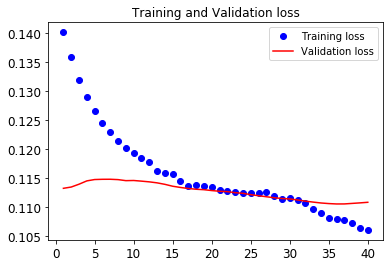

In [21]:
epochs = range(1, len(loss)+1)
plt.plot(epochs, smooth_curve(loss), 'bo', label='Training loss')
plt.plot(epochs, smooth_curve(val_loss), 'r-', label='Validation loss')
plt.legend()
plt.title('Training and Validation loss')
plt.show()

In [22]:
rnn_pred_train,rnn_pred_test,rnn_pr_train,rnn_pr_test= model_comparison_outputs_DNN(X_train,y_train, X_test, y_test, Base_rnn)

In [23]:
plot_recall_surplus_train_test(rnn_pr_train,rnn_pr_test)

## Deep RNN

In [24]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)

In [25]:
Deep_rnn = keras.models.Sequential([
    keras.layers.SimpleRNN(input_shape=[input_dim[0],input_dim[1]],units=40, activation="relu", return_sequences=True),
    keras.layers.Dropout(0.5),
    keras.layers.BatchNormalization(),
    keras.layers.SimpleRNN(20),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(units=10, activation='relu'),
    keras.layers.Dense(units=1, activation="sigmoid")
])

In [26]:
Deep_rnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, 9, 40)             1720      
_________________________________________________________________
dropout (Dropout)            (None, 9, 40)             0         
_________________________________________________________________
batch_normalization (BatchNo (None, 9, 40)             160       
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 20)                1220      
_________________________________________________________________
dropout_1 (Dropout)          (None, 20)                0         
_________________________________________________________________
dense (Dense)                (None, 10)                210       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 1

In [27]:
optimizer = keras.optimizers.Adam(lr=0.0001)
Deep_rnn.compile(loss="binary_crossentropy", optimizer=optimizer)

In [28]:
history = Deep_rnn.fit(X_train_aug, y_train_aug, epochs=50,
                    validation_data=(X_test, y_test))

Train on 1286 samples, validate on 345 samples
Epoch 1/50
1286/1286 [==============================] - 3s 2ms/sample - loss: 0.8197 - val_loss: 0.7039
Epoch 2/50
1286/1286 [==============================] - 1s 471us/sample - loss: 0.7765 - val_loss: 0.6842
Epoch 3/50
1286/1286 [==============================] - 1s 493us/sample - loss: 0.7319 - val_loss: 0.6600
Epoch 4/50
1286/1286 [==============================] - 1s 483us/sample - loss: 0.7110 - val_loss: 0.6329
Epoch 5/50
1286/1286 [==============================] - 1s 462us/sample - loss: 0.6767 - val_loss: 0.6064
Epoch 6/50
1286/1286 [==============================] - 1s 459us/sample - loss: 0.6606 - val_loss: 0.5784
Epoch 7/50
1286/1286 [==============================] - 1s 490us/sample - loss: 0.6297 - val_loss: 0.5504
Epoch 8/50
1286/1286 [==============================] - 1s 487us/sample - loss: 0.6092 - val_loss: 0.5258
Epoch 9/50
1286/1286 [==============================] - 1s 455us/sample - loss: 0.5739 - val_loss: 0.4990
E

In [29]:
loss = history.history['loss']
val_loss = history.history['val_loss']

Text(0.5, 1.0, 'Training and Validation loss')

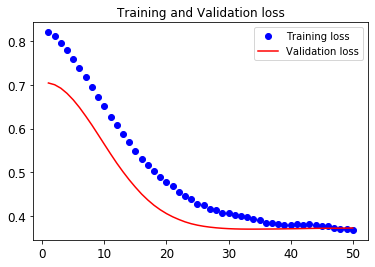

In [30]:
epochs = range(1, len(loss)+1)
plt.plot(epochs, smooth_curve(loss), 'bo', label='Training loss')
plt.plot(epochs, smooth_curve(val_loss), 'r-', label='Validation loss')
plt.legend()
plt.title('Training and Validation loss')
plt.show()

In [31]:
loss = history.history['loss'][10:]
val_loss = history.history['val_loss'][10:]

Text(0.5, 1.0, 'Training and Validation loss')

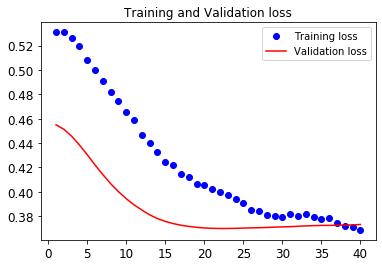

In [32]:
epochs = range(1, len(loss)+1)
plt.plot(epochs, smooth_curve(loss), 'bo', label='Training loss')
plt.plot(epochs, smooth_curve(val_loss), 'r-', label='Validation loss')
plt.legend()
plt.title('Training and Validation loss')
plt.show()

In [33]:
drnn_pred_train,drnn_pred_test,drnn_pr_train,drnn_pr_test= model_comparison_outputs_DNN(X_train,y_train, X_test, y_test, Deep_rnn)

plot_recall_surplus_train_test(drnn_pr_train,drnn_pr_test)

## Deep RNN with GRU

In [34]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)

In [35]:
Deep_GRU = keras.models.Sequential([
    keras.layers.GRU(input_shape=[input_dim[0],input_dim[1]],units=40,activation="relu",return_sequences=True),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.5),
    keras.layers.GRU(20),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(units=10, activation='relu'),
    keras.layers.Dense(units=1, activation="sigmoid")
])

Deep_GRU.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 9, 40)             5280      
_________________________________________________________________
batch_normalization (BatchNo (None, 9, 40)             160       
_________________________________________________________________
dropout (Dropout)            (None, 9, 40)             0         
_________________________________________________________________
gru_1 (GRU)                  (None, 20)                3720      
_________________________________________________________________
batch_normalization_1 (Batch (None, 20)                80        
_________________________________________________________________
dense (Dense)                (None, 10)                210       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 1

In [36]:
optimizer = keras.optimizers.Adam(lr=0.0001)
Deep_GRU.compile(loss="mse", optimizer=optimizer)

In [37]:
history = Deep_GRU.fit(X_train_aug, y_train_aug, epochs=50,
                    validation_data=(X_test, y_test))

Train on 1286 samples, validate on 345 samples
Epoch 1/50
1286/1286 [==============================] - 12s 10ms/sample - loss: 0.3140 - val_loss: 0.2506
Epoch 2/50
1286/1286 [==============================] - 1s 741us/sample - loss: 0.2797 - val_loss: 0.2428
Epoch 3/50
1286/1286 [==============================] - 1s 747us/sample - loss: 0.2565 - val_loss: 0.2350
Epoch 4/50
1286/1286 [==============================] - 1s 707us/sample - loss: 0.2378 - val_loss: 0.2261
Epoch 5/50
1286/1286 [==============================] - 1s 759us/sample - loss: 0.2253 - val_loss: 0.2154
Epoch 6/50
1286/1286 [==============================] - 1s 758us/sample - loss: 0.2108 - val_loss: 0.2042
Epoch 7/50
1286/1286 [==============================] - 1s 747us/sample - loss: 0.1935 - val_loss: 0.1926
Epoch 8/50
1286/1286 [==============================] - 1s 693us/sample - loss: 0.1886 - val_loss: 0.1825
Epoch 9/50
1286/1286 [==============================] - 1s 723us/sample - loss: 0.1807 - val_loss: 0.1728

In [38]:
loss = history.history['loss'][10:]
val_loss = history.history['val_loss'][10:]

Text(0.5, 1.0, 'Training and Validation loss')

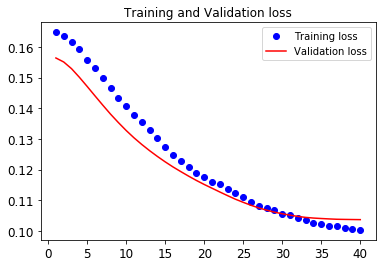

In [39]:
epochs = range(1, len(loss)+1)
plt.plot(epochs, smooth_curve(loss), 'bo', label='Training loss')
plt.plot(epochs, smooth_curve(val_loss), 'r-', label='Validation loss')
plt.legend()
plt.title('Training and Validation loss')
plt.show()

In [40]:
gru_pred_train,gru_pred_test,gru_pr_train,gru_pr_test= model_comparison_outputs_DNN(X_train,y_train, X_test, y_test, Deep_GRU)

plot_recall_surplus_train_test(gru_pr_train,gru_pr_test)

## Deep RNN with LSTM

In [41]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)

Deep_LSTM = keras.models.Sequential([
    keras.layers.LSTM(input_shape=[input_dim[0],input_dim[1]],units=40,activation="relu",return_sequences=True),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.3),
    keras.layers.SimpleRNN(20),
    keras.layers.Dense(units=10, activation='relu'),
    keras.layers.Dense(units=1, activation="sigmoid")
])

In [42]:
Deep_LSTM.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 9, 40)             6880      
_________________________________________________________________
batch_normalization (BatchNo (None, 9, 40)             160       
_________________________________________________________________
dropout (Dropout)            (None, 9, 40)             0         
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 20)                1220      
_________________________________________________________________
dense (Dense)                (None, 10)                210       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 11        
Total params: 8,481
Trainable params: 8,401
Non-trainable params: 80
_____________________________________________________

In [43]:
optimizer = keras.optimizers.Adam(lr=0.0001)
Deep_LSTM.compile(loss="mse", optimizer=optimizer)

In [44]:
history = Deep_LSTM.fit(X_train_aug, y_train_aug, epochs=100,
                    validation_data=(X_test, y_test))

loss = history.history['loss'][10:]
val_loss = history.history['val_loss'][10:]

Train on 1286 samples, validate on 345 samples
Epoch 1/100
1286/1286 [==============================] - 3s 3ms/sample - loss: 0.2782 - val_loss: 0.2555
Epoch 2/100
1286/1286 [==============================] - 1s 909us/sample - loss: 0.2500 - val_loss: 0.2464
Epoch 3/100
1286/1286 [==============================] - 1s 938us/sample - loss: 0.2254 - val_loss: 0.2362
Epoch 4/100
1286/1286 [==============================] - 1s 828us/sample - loss: 0.2051 - val_loss: 0.2242
Epoch 5/100
1286/1286 [==============================] - 1s 848us/sample - loss: 0.1884 - val_loss: 0.2106
Epoch 6/100
1286/1286 [==============================] - 1s 723us/sample - loss: 0.1763 - val_loss: 0.1964
Epoch 7/100
1286/1286 [==============================] - 1s 684us/sample - loss: 0.1606 - val_loss: 0.1813
Epoch 8/100
1286/1286 [==============================] - 1s 790us/sample - loss: 0.1508 - val_loss: 0.1673
Epoch 9/100
1286/1286 [==============================] - 1s 797us/sample - loss: 0.1393 - val_loss:

1286/1286 [==============================] - 1s 812us/sample - loss: 0.0957 - val_loss: 0.1036
Epoch 77/100
1286/1286 [==============================] - 1s 703us/sample - loss: 0.0960 - val_loss: 0.1035
Epoch 78/100
1286/1286 [==============================] - 1s 746us/sample - loss: 0.0953 - val_loss: 0.1038
Epoch 79/100
1286/1286 [==============================] - 1s 723us/sample - loss: 0.0952 - val_loss: 0.1037
Epoch 80/100
1286/1286 [==============================] - 1s 720us/sample - loss: 0.0953 - val_loss: 0.1036
Epoch 81/100
1286/1286 [==============================] - 1s 688us/sample - loss: 0.0962 - val_loss: 0.1035
Epoch 82/100
1286/1286 [==============================] - 1s 697us/sample - loss: 0.0962 - val_loss: 0.1034
Epoch 83/100
1286/1286 [==============================] - 1s 675us/sample - loss: 0.0947 - val_loss: 0.1032
Epoch 84/100
1286/1286 [==============================] - 1s 716us/sample - loss: 0.0954 - val_loss: 0.1036
Epoch 85/100
1286/1286 [=================

Text(0.5, 1.0, 'Training and Validation loss')

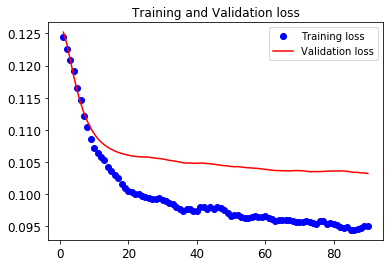

In [45]:
epochs = range(1, len(loss)+1)
plt.plot(epochs, smooth_curve(loss), 'bo', label='Training loss')
plt.plot(epochs, smooth_curve(val_loss), 'r-', label='Validation loss')
plt.legend()
plt.title('Training and Validation loss')
plt.show()

lstm_pred_train,lstm_pred_test,lstm_pr_train,lstm_pr_test= model_comparison_outputs_DNN(X_train,y_train, X_test, y_test, Deep_LSTM)

plot_recall_surplus_train_test(lstm_pr_train,lstm_pr_test)

# Results summary

## RNN models comparison

In [46]:
    trace0=go.Scatter(
            y=rnn_pr_test.recall-rnn_pr_test.positives_share,
            x=rnn_pr_test.positives_share,
            mode='lines',
            marker=dict(
            color="blue",
            size=5,
            opacity=0.5
            ),
            name="Single RNN layer"
        )
    
    trace1=go.Scatter(
            y=drnn_pr_test.recall-drnn_pr_test.positives_share,
            x=drnn_pr_test.positives_share,
            mode='lines',
            marker=dict(
            color="red",
            size=5,
            opacity=0.5
            ),
            name="Deep RNN"
        )
    
    trace2=go.Scatter(
            y=gru_pr_test.recall-gru_pr_test.positives_share,
            x=gru_pr_test.positives_share,
            mode='lines',
            marker=dict(
            color="green",
            size=5,
            opacity=0.5
            ),
            name="RNN with GRU cells"
        )

    trace3=go.Scatter(
            y=lstm_pr_test.recall-lstm_pr_test.positives_share,
            x=lstm_pr_test.positives_share,
            mode='lines',
            marker=dict(
            color="yellow",
            size=5,
            opacity=0.5
            ),
            name="RNN with LSTM cells"
        )

    



    data=[trace0, trace1,trace2,trace3]
    figure=go.Figure(
        data=data,
        layout=go.Layout(
            title="Recall surplus in relation to Postives Share",
            yaxis=dict(title="Recall surplus"),
            xaxis=dict(title="Positives share", range=[0,0.4]),
            legend=dict(
                x=0.76,
                y=0,
                traceorder="normal",
                font=dict(
                    family="sans-serif",
                    size=12,
                    color="black"
                ),
            bgcolor=None


        )))
    iplot(figure)

## Base ML models and RNN comparison

In [49]:
RF_pr_test=pd.read_excel("Random_Forest_summary.xlsx")

DNN_test=pd.read_excel("DNN_summary.xlsx")

Ensemble_pr_test=pd.read_excel("Ensemble_summary.xlsx")

In [50]:
    trace0=go.Scatter(
            y=RF_pr_test.recall-RF_pr_test.positives_share,
            x=RF_pr_test.positives_share,
            mode='lines',
            marker=dict(
            color="blue",
            size=5,
            opacity=0.5
            ),
            name="Random Forest Classifier"
        )
    
    trace1=go.Scatter(
            y=DNN_test.recall-DNN_test.positives_share,
            x=DNN_test.positives_share,
            mode='lines',
            marker=dict(
            color="red",
            size=5,
            opacity=0.5
            ),
            name="Fully connected DNN"
        )
    
    trace2=go.Scatter(
            y=gru_pr_test.recall-gru_pr_test.positives_share,
            x=gru_pr_test.positives_share,
            mode='lines',
            marker=dict(
            color="green",
            size=5,
            opacity=0.5
            ),
            name="RNN with GRU cells"
        )

    trace3=go.Scatter(
            y=Ensemble_pr_test.recall-Ensemble_pr_test.positives_share,
            x=Ensemble_pr_test.positives_share,
            mode='lines',
            marker=dict(
            color="yellow",
            size=5,
            opacity=0.5
            ),
            name="Ensemble Model"
        )

    



    data=[trace0, trace1,trace2,trace3]
    figure=go.Figure(
        data=data,
        layout=go.Layout(
            title="Recall surplus in relation to Postives Share",
            yaxis=dict(title="Recall surplus"),
            xaxis=dict(title="Positives share", range=[0,0.4]),
            legend=dict(
                x=0.76,
                y=0,
                traceorder="normal",
                font=dict(
                    family="sans-serif",
                    size=12,
                    color="black"
                ),
            bgcolor=None


        )))
    iplot(figure)

In [51]:
    trace0=go.Scatter(
            y=RF_pr_test.recall,
            x=RF_pr_test.positives_share,
            mode='lines',
            marker=dict(
            color="blue",
            size=5,
            opacity=0.5
            ),
            name="Random Forest Classifier"
        )
    
    trace1=go.Scatter(
            y=DNN_test.recall,
            x=DNN_test.positives_share,
            mode='lines',
            marker=dict(
            color="red",
            size=5,
            opacity=0.5
            ),
            name="Fully connected DNN"
        )
    
    trace2=go.Scatter(
            y=gru_pr_test.recall,
            x=gru_pr_test.positives_share,
            mode='lines',
            marker=dict(
            color="green",
            size=5,
            opacity=0.5
            ),
            name="RNN with GRU cells"
        )

    trace3=go.Scatter(
            y=Ensemble_pr_test.recall,
            x=Ensemble_pr_test.positives_share,
            mode='lines',
            marker=dict(
            color="yellow",
            size=5,
            opacity=0.5
            ),
            name="Ensemble Model"
        )

    



    data=[trace0, trace1,trace2,trace3]
    figure=go.Figure(
        data=data,
        layout=go.Layout(
            title="Recall in relation to Postives Share",
            yaxis=dict(title="Recall"),
            xaxis=dict(title="Positives share", range=[0,0.4]),
            legend=dict(
                x=0.76,
                y=0,
                traceorder="normal",
                font=dict(
                    family="sans-serif",
                    size=12,
                    color="black"
                ),
            bgcolor=None


        )))
    iplot(figure)

## Best model characteristic

In [52]:
    trace0=go.Scatter(
            y=gru_pr_test.recall,
            x=gru_pr_test.positives_share,
            mode='lines',
            marker=dict(
            color="green",
            size=5,
            opacity=0.5
            ),
            name="RNN with GRU cells"
        )

    trace1=go.Scatter(
            y=np.ones(gru_pr_test.positives_share.shape)*0.835,
            x=gru_pr_test.positives_share,
            mode='lines',
            marker=dict(
            color="black",
            size=5,
            opacity=0.5
            ),
            name="Bayes unavoidable error"
        )

    trace2=go.Scatter(
            y=gru_pr_test.positives_share,
            x=gru_pr_test.positives_share,
            mode='lines',
            marker=dict(
            color="blue",
            size=5,
            opacity=0.5
            ),
            name="Random screening"
        )

    



    data=[trace0, trace1,trace2]
    figure=go.Figure(
        data=data,
        layout=go.Layout(
            title="Recall in relation to Postives Share",
            yaxis=dict(title="Recall"),
            xaxis=dict(title="Positives share", range=[0,0.4]),
            legend=dict(
                x=0.73,
                y=0,
                traceorder="normal",
                font=dict(
                    family="sans-serif",
                    size=12,
                    color="black"
                ),
            bgcolor=None


        )))
    iplot(figure)

In [53]:
    trace0=go.Scatter(
            y=gru_pr_test.recall,
            x=gru_pr_test.positives_share,
            mode='lines',
            marker=dict(
            color="green",
            size=5,
            opacity=0.5
            ),
            name="Recall"
        )



    trace1=go.Scatter(
            y=gru_pr_test.precission,
            x=gru_pr_test.positives_share,
            mode='lines',
            marker=dict(
            color="blue",
            size=5,
            opacity=0.5
            ),
            name="Precision"
        )

    



    data=[trace0, trace1]
    figure=go.Figure(
        data=data,
        layout=go.Layout(
            title="Precision and Recall Curve",
            yaxis=dict(title=""),
            xaxis=dict(title="Positives share",range=[0.015,0.4]),
            legend=dict(
                x=0.85,
                y=0,
                traceorder="normal",
                font=dict(
                    family="sans-serif",
                    size=12,
                    color="black"
                ),
            bgcolor=None


        )))
    iplot(figure)

In [54]:
gru_pred_test["risk_category"]=pd.qcut(gru_pred_test.y_pred, 5, labels=["safe", "low risk", "moderate risk","high risk","very high risk"])

In [55]:
risk_performance=gru_pred_test.groupby("risk_category").y_true.mean().reset_index()

In [56]:
risk_performance["default_count"]=gru_pred_test.groupby("risk_category").y_true.sum().values

In [57]:
risk_performance["share_of_defaults"]=risk_performance["default_count"]/gru_pred_test.y_true.sum()

In [58]:
fig = go.Figure(data=[
    go.Bar(name='Default Probability', x=risk_performance.risk_category, y=risk_performance.y_true),
    go.Scatter(
        x=risk_performance.risk_category,
        y=np.ones(5)*gru_pred_test.y_true.mean(),
        name='Portfolio average')
    
])

In [59]:
fig.update_layout(barmode='group',yaxis=dict(title="Default Probability"), legend=dict(
                x=0.1,
                y=1,
                traceorder="normal",
                font=dict(
                    family="sans-serif",
                    size=12,
                    color="black"
                ),
            bgcolor=None))

In [60]:
fig = go.Figure(data=[
    go.Bar(name='Share of all defaults within risk category', x=risk_performance.risk_category, y=risk_performance["share_of_defaults"]),
]);


# Change the bar mode
fig.update_layout(barmode='group',yaxis=dict(title="% of total portfolio defaults"),)